In [1]:
# Required packages
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

print("Tensorflow version is", tf.__version__)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version is 1.8.0


Using TensorFlow backend.


In [2]:
def load_image(infile:str):
    """
        Input: String
        Output: Numpy Array
        Takes in name of image file and loads it into a numpy array.
    """
    # Open the image file
    img = Image.open(infile)
    
    # Load image
    img.load()
    
    # Convert to numpy array
    data = np.asarray(img, dtype='int32')
    
    return data

In [3]:
img_size = 128
channels = 3

In [4]:
def create_dataset(root_folder:str) -> ('np.array', 'np.array'):
    """
        Input: String
        Output: Numpy Array, Numpy Array
        Takes in name of the root location of image files and returns X and y dataset.
    """
    X = None
    y = []
    
    for folder in os.listdir(root_folder):
        if folder == '.DS_Store':
            continue
        for (dirpath, dirnames, filenames) in os.walk(os.path.join(root_folder, folder)):
            for file in filenames:
                infile = os.path.join(dirpath, file)
                try:
                    img = load_image(infile)
                    img = img.reshape((-1, img_size, img_size, channels))
                    
                    if X is not None:
                        X = np.vstack((X, img))
                    else:
                        X = img
                        
                    y.append(folder)
                except IOError as ioe:
                    print(ioe)
    y = np.array(y)
    return X, y

In [5]:
X, y = create_dataset('photos_min')

cannot identify image file 'photos_min/me/.DS_Store'


In [6]:
X.shape, y.shape

((313, 128, 128, 3), (313,))

In [7]:
unique_values = ['me', 'notme']

def class_to_int(y:'np.array') -> 'np.array':
    """
        Input: Numpy Array
        Output: Numpy Array
        Converts Class Names to Integers
    """
    
    y_new = np.zeros(y.shape)
    
    for index, value in enumerate(y):
        y_new[index] = unique_values.index(value)
    
    return y_new

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

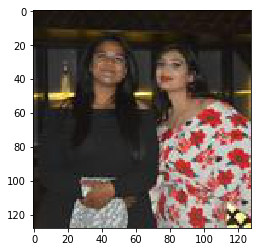

In [9]:
plt.imshow(X_train[5].reshape(128, 128, 3))
plt.show()

In [10]:
y_train = class_to_int(y_train)
y_train = to_categorical(y_train)
y_test = class_to_int(y_test)
y_test = to_categorical(y_test)

In [11]:
img_shape = (128, 128, 3)

base_model = tf.keras.applications.MobileNet(input_shape=img_shape, include_top=False, weights='imagenet')

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [14]:
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=30, 
                                                       featurewise_center=True, 
                                                       featurewise_std_normalization=True,  
                                                       width_shift_range=0.2, 
                                                       height_shift_range=0.2, 
                                                       horizontal_flip=True, 
                                                       vertical_flip=True, 
                                                       rescale=1.1)

In [15]:
datagen.fit(X_train.astype('float32'))

In [16]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(2, activation='softmax')
])

In [17]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [19]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

In [20]:
model.fit_generator(datagen.flow(X_train.astype('float32'), y_train), 
                    validation_data=(X_test.astype('float32'), y_test), 
                    epochs=50, 
                    callbacks=[checkpoint])

Epoch 1/50
7/8 [=========================>....] - ETA: 1s - loss: 0.9213 - acc: 0.5443
Epoch 00001: val_acc improved from -inf to 0.60317, saving model to best_model.hdf5
8/8 [==============================] - 20s 3s/step - loss: 0.9462 - acc: 0.5385 - val_loss: 1.0554 - val_acc: 0.6032
Epoch 2/50
7/8 [=========================>....] - ETA: 1s - loss: 0.9505 - acc: 0.5474
Epoch 00002: val_acc did not improve
8/8 [==============================] - 13s 2s/step - loss: 0.9753 - acc: 0.5383 - val_loss: 1.0420 - val_acc: 0.5873
Epoch 3/50
7/8 [=========================>....] - ETA: 1s - loss: 0.9178 - acc: 0.5230
Epoch 00003: val_acc did not improve
8/8 [==============================] - 13s 2s/step - loss: 0.9517 - acc: 0.5158 - val_loss: 1.0180 - val_acc: 0.5873
Epoch 4/50
7/8 [=========================>....] - ETA: 1s - loss: 1.0088 - acc: 0.4897
Epoch 00004: val_acc did not improve
8/8 [==============================] - 14s 2s/step - loss: 1.0161 - acc: 0.4867 - val_loss: 1.0007 - val_a

Epoch 35/50
7/8 [=========================>....] - ETA: 1s - loss: 0.5441 - acc: 0.7115
Epoch 00035: val_acc did not improve
8/8 [==============================] - 13s 2s/step - loss: 0.5028 - acc: 0.7437 - val_loss: 0.9023 - val_acc: 0.5714
Epoch 36/50
7/8 [=========================>....] - ETA: 1s - loss: 0.5524 - acc: 0.7026
Epoch 00036: val_acc did not improve
8/8 [==============================] - 13s 2s/step - loss: 0.5596 - acc: 0.7085 - val_loss: 0.8987 - val_acc: 0.5714
Epoch 37/50
7/8 [=========================>....] - ETA: 1s - loss: 0.4939 - acc: 0.7806
Epoch 00037: val_acc did not improve
8/8 [==============================] - 13s 2s/step - loss: 0.4781 - acc: 0.7767 - val_loss: 0.8810 - val_acc: 0.5714
Epoch 38/50
7/8 [=========================>....] - ETA: 1s - loss: 0.5146 - acc: 0.7548
Epoch 00038: val_acc did not improve
8/8 [==============================] - 13s 2s/step - loss: 0.5199 - acc: 0.7422 - val_loss: 0.8895 - val_acc: 0.5714
Epoch 39/50
7/8 [===============

In [21]:
model.save('RecogMe.hdf5')